In [2]:
# python 3.10.14
import seaborn as sns # 0.13.2
import matplotlib.pyplot as plt # 3.8.4
import numpy as np  # 1.23.2
import pandas as pd # 2.2.2


# to make this notebook's output stable across runs (still not fully deterministic)
SEED = 42
np.random.seed(SEED)


In [3]:
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18
#
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Define the colors for the plots
BACKGROUND_COL = '#F2F2F2'
AXIS_COLOR     = '#BEBEBE' 
LINES_COLOR    = '#BEBEBE'
sns.set_style("whitegrid", {'grid.linestyle': '--',
                            'grid.color': LINES_COLOR,
                            'axes.edgecolor': AXIS_COLOR,
                            'axes.facecolor':BACKGROUND_COL,
                            'figure.facecolor':BACKGROUND_COL,
                            })
plt.rcParams['axes.facecolor'] = BACKGROUND_COL

%matplotlib inline
%config InlineBackend.figure_format='retina' 

### Data downloading

In [42]:
#! mkdir -p data
#! wget "https://archive.ics.uci.edu/static/public/915/differentiated+thyroid+cancer+recurrence.zip"
#! unzip *.zip -d ./data
#! rm -f *.zip

In [77]:
DATA = pd.read_csv('./data/Thyroid_Diff.csv')
# check nan in dataframe
assert DATA.isna().sum().sum() == 0
DATA.columns

Index(['Age', 'Gender', 'Smoking', 'Hx Smoking', 'Hx Radiothreapy',
       'Thyroid Function', 'Physical Examination', 'Adenopathy', 'Pathology',
       'Focality', 'Risk', 'T', 'N', 'M', 'Stage', 'Response', 'Recurred'],
      dtype='object')

In [79]:
# Define a dictionary of column names and their corresponding custom orders
custom_orders = {
    'Stage': ['I', 'II', 'III', 'IVA', 'IVB'],
    'N': ['N0', 'N1a', 'N1b'],
    'T': ['T1a', 'T1b', 'T2', 'T3a', 'T3b', 'T4a', 'T4b'],
    'Risk': ['Low', 'Intermediate', 'High'],
    'Recurred': ['Yes', 'No']
}

# Apply the custom orders using a for loop
for col, order in custom_orders.items():
    DATA[col] = pd.Categorical(DATA[col], categories=order, ordered=True)
    print(f"{col} dtype: {DATA[col].unique()}")


Stage dtype: ['I', 'II', 'IVB', 'III', 'IVA']
Categories (5, object): ['I' < 'II' < 'III' < 'IVA' < 'IVB']
N dtype: ['N0', 'N1b', 'N1a']
Categories (3, object): ['N0' < 'N1a' < 'N1b']
T dtype: ['T1a', 'T1b', 'T2', 'T3a', 'T3b', 'T4a', 'T4b']
Categories (7, object): ['T1a' < 'T1b' < 'T2' < 'T3a' < 'T3b' < 'T4a' < 'T4b']
Risk dtype: ['Low', 'Intermediate', 'High']
Categories (3, object): ['Low' < 'Intermediate' < 'High']
Recurred dtype: ['No', 'Yes']
Categories (2, object): ['Yes' < 'No']


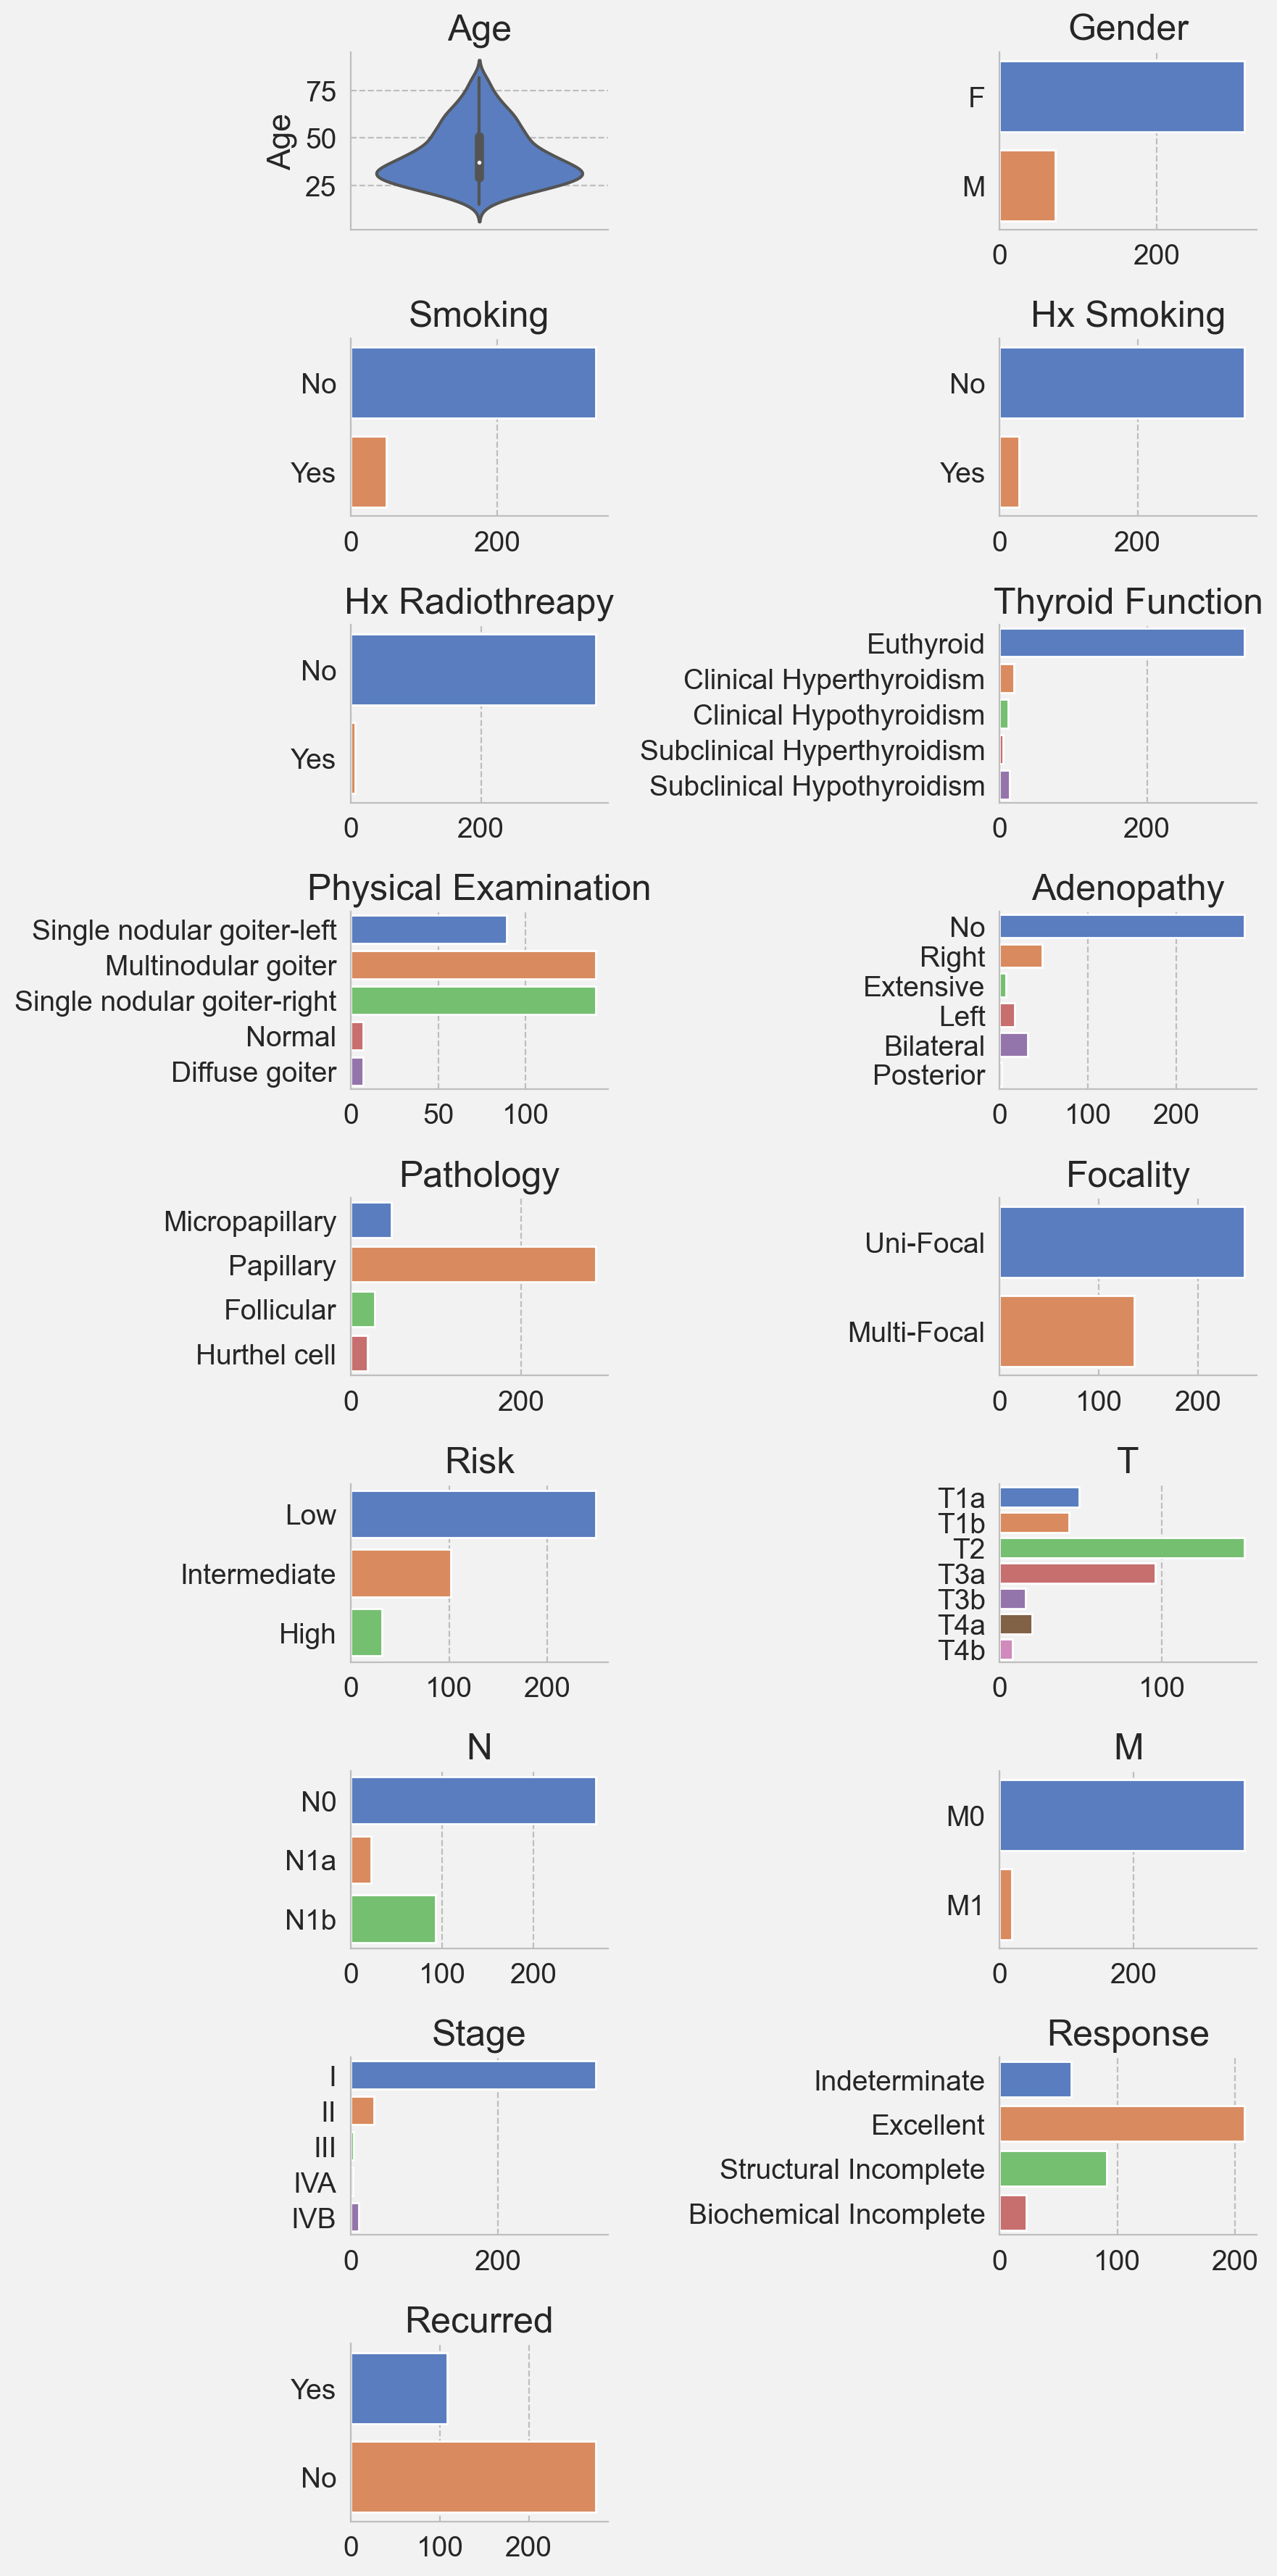

In [80]:


# Detect categorical and numeric columns
categorical_cols = DATA.select_dtypes(include=["object", "category"]).columns
numeric_cols = DATA.select_dtypes(include=["number"]).columns

# Initialize grid layout
n_cols = 2  # Number of columns in the grid
n_rows = int(np.ceil(len(DATA.columns) / n_cols))  # Calculate rows based on number of columns
fig, axes = plt.subplots(n_rows, n_cols, figsize=(9, 2 * n_rows))

# Flatten axes for easy iteration
axes = axes.flatten()

# Loop through each column and create the appropriate plot
for idx, col in enumerate(DATA.columns):
    ax = axes[idx]  # Get the axis to plot on

    # Categorical columns: Bar plots
    if col in categorical_cols:
        sns.countplot(data=DATA, y=col, palette="muted", ax=ax)
        ax.set_title(col)
        ax.set_ylabel("")

    # Numeric columns: Violin plots
    elif col in numeric_cols:
        sns.violinplot(data=DATA, y=col, palette="muted", ax=ax)
        ax.set_title(col)

    # Hide x-axis for numeric plots (only used for categorical)
    #if col in numeric_cols:
    ax.set_xlabel("")

# Hide any unused subplots in the grid
for idx in range(len(DATA.columns), len(axes)):
    fig.delaxes(axes[idx])

# Adjust layout and spacing
sns.despine()
plt.tight_layout()
plt.show()

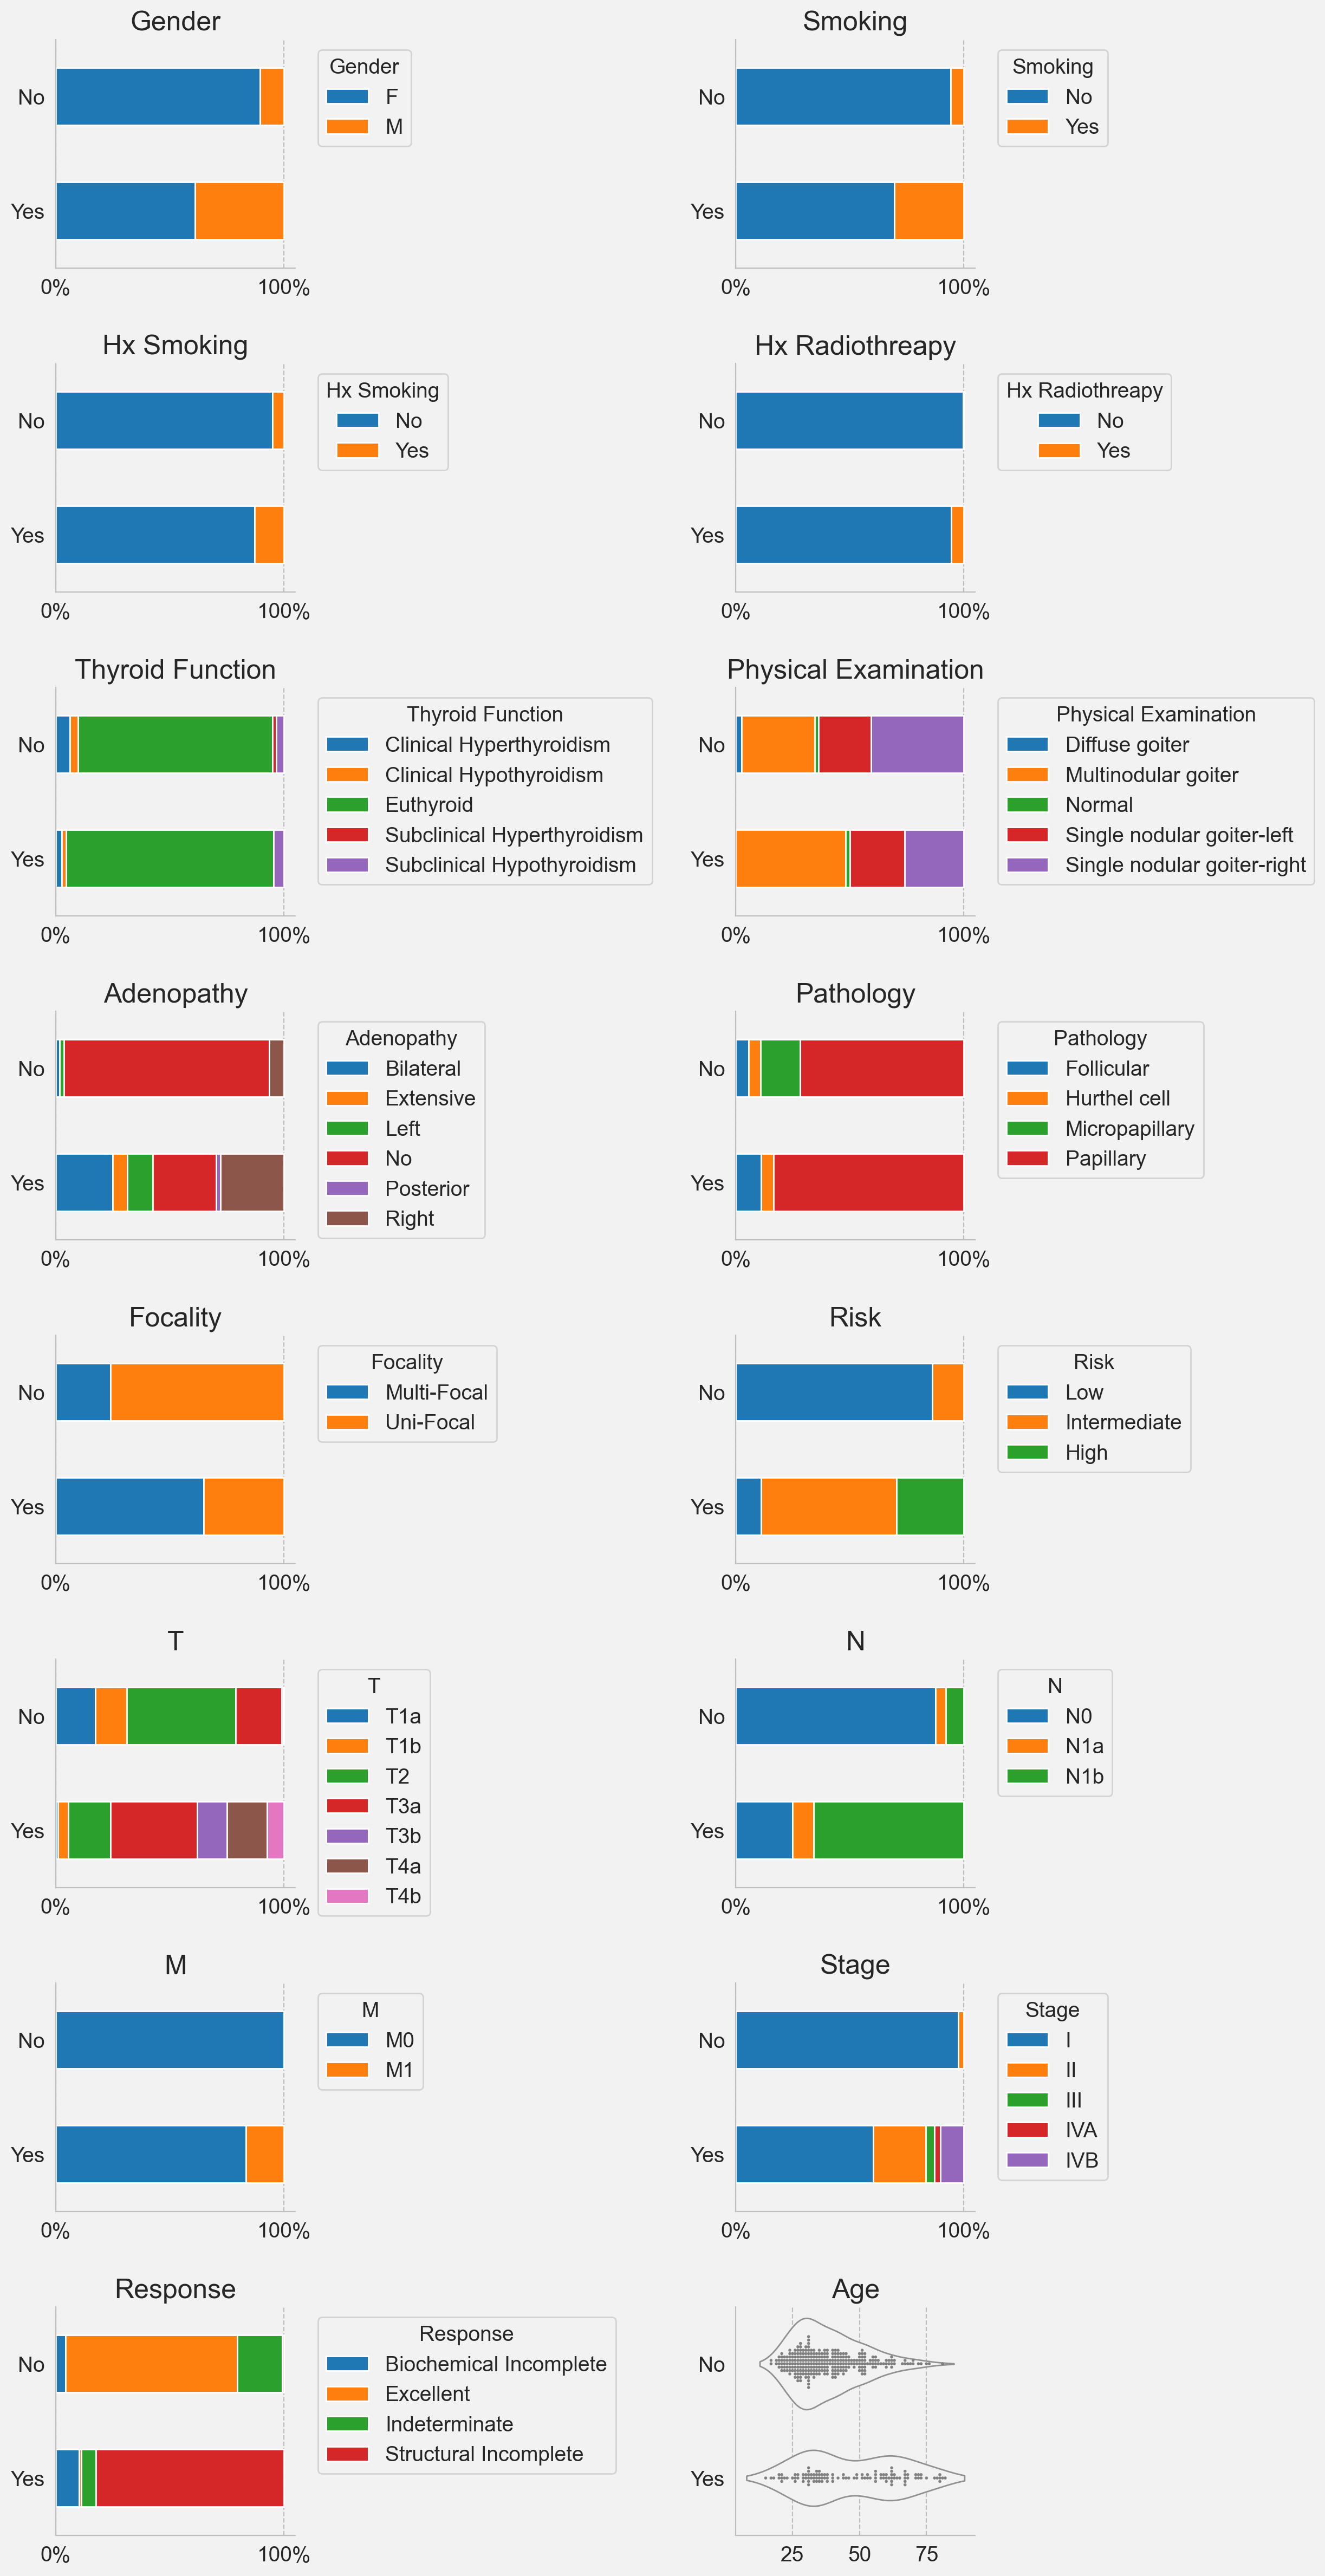

In [81]:
def stratified_plots(data, stratify_col="Recurred"):
    """
    Generate stratified plots for categorical and numeric columns by a specified column.
    Percentage stacked bar plots for categorical features and violin plots for numeric features.
    
    Parameters:
        data (pd.DataFrame): Input DataFrame.
        stratify_col (str): Column name by which to stratify (e.g., "Recurred").
    """
    # Check if the stratify column exists
    if stratify_col not in data.columns:
        raise ValueError(f"{stratify_col} column not found in the dataset.")
    
    # Detect categorical and numeric columns
    categorical_cols = data.select_dtypes(include=["object", "category"]).columns
    numeric_cols = data.select_dtypes(include=["number"]).columns
    
    # Exclude the stratify column from categorical/numeric columns
    categorical_cols = [col for col in categorical_cols if col != stratify_col]
    numeric_cols = [col for col in numeric_cols if col != stratify_col]

    # Combine columns to iterate through all
    all_cols = categorical_cols + numeric_cols
    n_cols = 2  # Number of columns in the grid
    n_rows = int(np.ceil(len(all_cols) / n_cols))  # Calculate rows based on number of columns
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 3 * n_rows))
    
    # Flatten axes for easy iteration
    axes = axes.flatten()
    
    # Loop through each column and create the appropriate plot
    for idx, col in enumerate(all_cols):
        ax = axes[idx]  # Get the axis to plot on
        
        # Categorical columns: Percentage stacked bar plots
        if col in categorical_cols:
            # Calculate percentages
            grouped = data.groupby([stratify_col, col]).size().unstack(fill_value=0)
            percentages = grouped.div(grouped.sum(axis=1), axis=0) * 100
            percentages.plot(kind="barh", stacked=True, ax=ax, )
            ax.set_title(col)
            ax.set_ylabel("")
            ax.set_xlabel("")
            # Set x-ticks to 0% and 100% only
            ax.set_xticks([0, 100])
            ax.set_xticklabels(["0%", "100%"])
            ax.grid(axis='y', visible=False)  # Hides horizontal gridlines

            ax.legend(title=col, bbox_to_anchor=(1.05, 1), loc="upper left")

        # Numeric columns: Violin plots
        elif col in numeric_cols:
            order= ['No', 'Yes']
            sns.violinplot(data=data, x=col, y=stratify_col, order=order, ax=ax, inner=None, linewidth=1, color="#F2F2F2", cut=1)
            sns.swarmplot(data=data, x=col, y=stratify_col, order=order,   color='grey', ax=ax, size=2, )

            ax.set_title(col)
            ax.set_ylabel("")
            ax.set_xlabel("")
        
    # Hide any unused subplots in the grid
    for idx in range(len(all_cols), len(axes)):
        fig.delaxes(axes[idx])
    
    # Adjust layout and spacing
    sns.despine()
    plt.tight_layout(rect=[0, 0, 0.9, 1])  # Add space for legends
    plt.show()

stratified_plots(DATA, stratify_col="Recurred")

In [89]:
ORD_FEATURES = ['Stage','N','T','Risk']
CAT_FEATURES  = ['Thyroid Function', 'Physical Examination', 'Adenopathy', 'Pathology','Response',
                    'Gender', 'Smoking', 'Hx Smoking', 'Hx Radiothreapy','M', 'Focality']
NUM_FEATURES = ['Age']

In [111]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder


In [112]:
Y = LabelEncoder().fit_transform( DATA["Recurred"])

In [118]:
X = DATA.drop(columns=["Recurred"])
# Combine into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', NUM_FEATURES),  # skip
        ('ord', OrdinalEncoder(categories=[custom_orders[feature] for feature in ORD_FEATURES]), ORD_FEATURES),   # Apply OrdinalEncoder with custom order
        ('cat', OneHotEncoder(drop='first'), CAT_FEATURES) # Apply OneHotEncoder to categorical features
    ]
)

# Fit and transform the data
X = preprocessor.fit_transform(X)

# If you need to wrap the result in a DataFrame, include column names
# Note: OneHotEncoder produces multiple columns per feature
# You might need to extract the feature names from the transformer
X = pd.DataFrame(
    X,
    columns=(
        NUM_FEATURES + ORD_FEATURES + 
        list(preprocessor.named_transformers_['cat'].get_feature_names_out(CAT_FEATURES))
    )
)


In [ ]:
# display unique values for each column
for col in X.columns:
    print(f"{col}: {X[col].unique()}")
X

Age: [27. 34. 30. 62. 52. 41. 46. 51. 40. 75. 59. 49. 50. 76. 42. 44. 43. 36.
 70. 60. 33. 26. 37. 55. 31. 45. 20. 38. 29. 25. 21. 23. 24. 35. 54. 22.
 69. 28. 17. 73. 18. 39. 57. 66. 32. 47. 56. 63. 19. 67. 72. 61. 68. 48.
 81. 53. 58. 80. 79. 65. 15. 82. 71. 64. 78.]
Stage: [0. 1. 4. 2. 3.]
N: [0. 2. 1.]
T: [0. 1. 2. 3. 4. 5. 6.]
Risk: [0. 1. 2.]
Thyroid Function_Clinical Hypothyroidism: [0. 1.]
Thyroid Function_Euthyroid: [1. 0.]
Thyroid Function_Subclinical Hyperthyroidism: [0. 1.]
Thyroid Function_Subclinical Hypothyroidism: [0. 1.]
Physical Examination_Multinodular goiter: [0. 1.]
Physical Examination_Normal: [0. 1.]
Physical Examination_Single nodular goiter-left: [1. 0.]
Physical Examination_Single nodular goiter-right: [0. 1.]
Adenopathy_Extensive: [0. 1.]
Adenopathy_Left: [0. 1.]
Adenopathy_No: [1. 0.]
Adenopathy_Posterior: [0. 1.]
Adenopathy_Right: [0. 1.]
Pathology_Hurthel cell: [0. 1.]
Pathology_Micropapillary: [1. 0.]
Pathology_Papillary: [0. 1.]
Response_Excellent: [0. 1

Age  Stage    N    T  Risk  Thyroid Function_Clinical Hypothyroidism  \
0    27.0    0.0  0.0  0.0   0.0                                       0.0   
1    34.0    0.0  0.0  0.0   0.0                                       0.0   
2    30.0    0.0  0.0  0.0   0.0                                       0.0   
3    62.0    0.0  0.0  0.0   0.0                                       0.0   
4    62.0    0.0  0.0  0.0   0.0                                       0.0   
..    ...    ...  ...  ...   ...                                       ...   
378  72.0    4.0  2.0  6.0   2.0                                       0.0   
379  81.0    4.0  2.0  6.0   2.0                                       0.0   
380  72.0    4.0  2.0  6.0   2.0                                       0.0   
381  61.0    3.0  2.0  6.0   2.0                                       0.0   
382  67.0    3.0  2.0  6.0   2.0                                       0.0   

     Thyroid Function_Euthyroid  Thyroid Function_Subclinical Hyperthyroidism  \
0                           1.0                                           0.0   
1                           1.0                                           0.0   
2                           1.0                                           0.0   
3                           1.0                                           0.0   
4                           1.0                                           0.0   
..                          ...                                           ...   
378                         1.0                                           0.0   
379                         1.0                                           0.0   
380                         1.0                                           0.0   
381                         0.0                                           0.0   
382                         1.0                                           0.0   

     Thyroid Function_Subclinical Hypothyroidism  \
0                                            0.0   
1                                            0.0   
2                                            0.0   
3                                            0.0   
4                                            0.0   
..                                           ...   
378                                          0.0   
379                                          0.0   
380                                          0.0   
381                                          0.0   
382                                          0.0   

     Physical Examination_Multinodular goiter  ...  Pathology_Papillary  \
0                                         0.0  ...                  0.0   
1                                         1.0  ...                  0.0   
2                                         0.0  ...                  0.0   
3                                         0.0  ...                  0.0   
4                                         1.0  ...                  0.0   
..                                        ...  ...                  ...   
378                                       0.0  ...                  1.0   
379                                       1.0  ...                  1.0   
380                                       1.0  ...                  1.0   
381                                       1.0  ...                  0.0   
382                                       1.0  ...                  1.0   

     Response_Excellent  Response_Indeterminate  \
0                   0.0                     1.0   
1                   1.0                     0.0   
2                   1.0                     0.0   
3                   1.0                     0.0   
4                   1.0                     0.0   
..                  ...                     ...   
378                 0.0                     0.0   
379                 0.0                     0.0   
380                 0.0                     0.0   
381                 0.0                     0.0   
382      

In [133]:
from sklearn.preprocessing import MinMaxScaler

X = MinMaxScaler().fit_transform(X)

In [134]:
from sklearn.decomposition import PCA


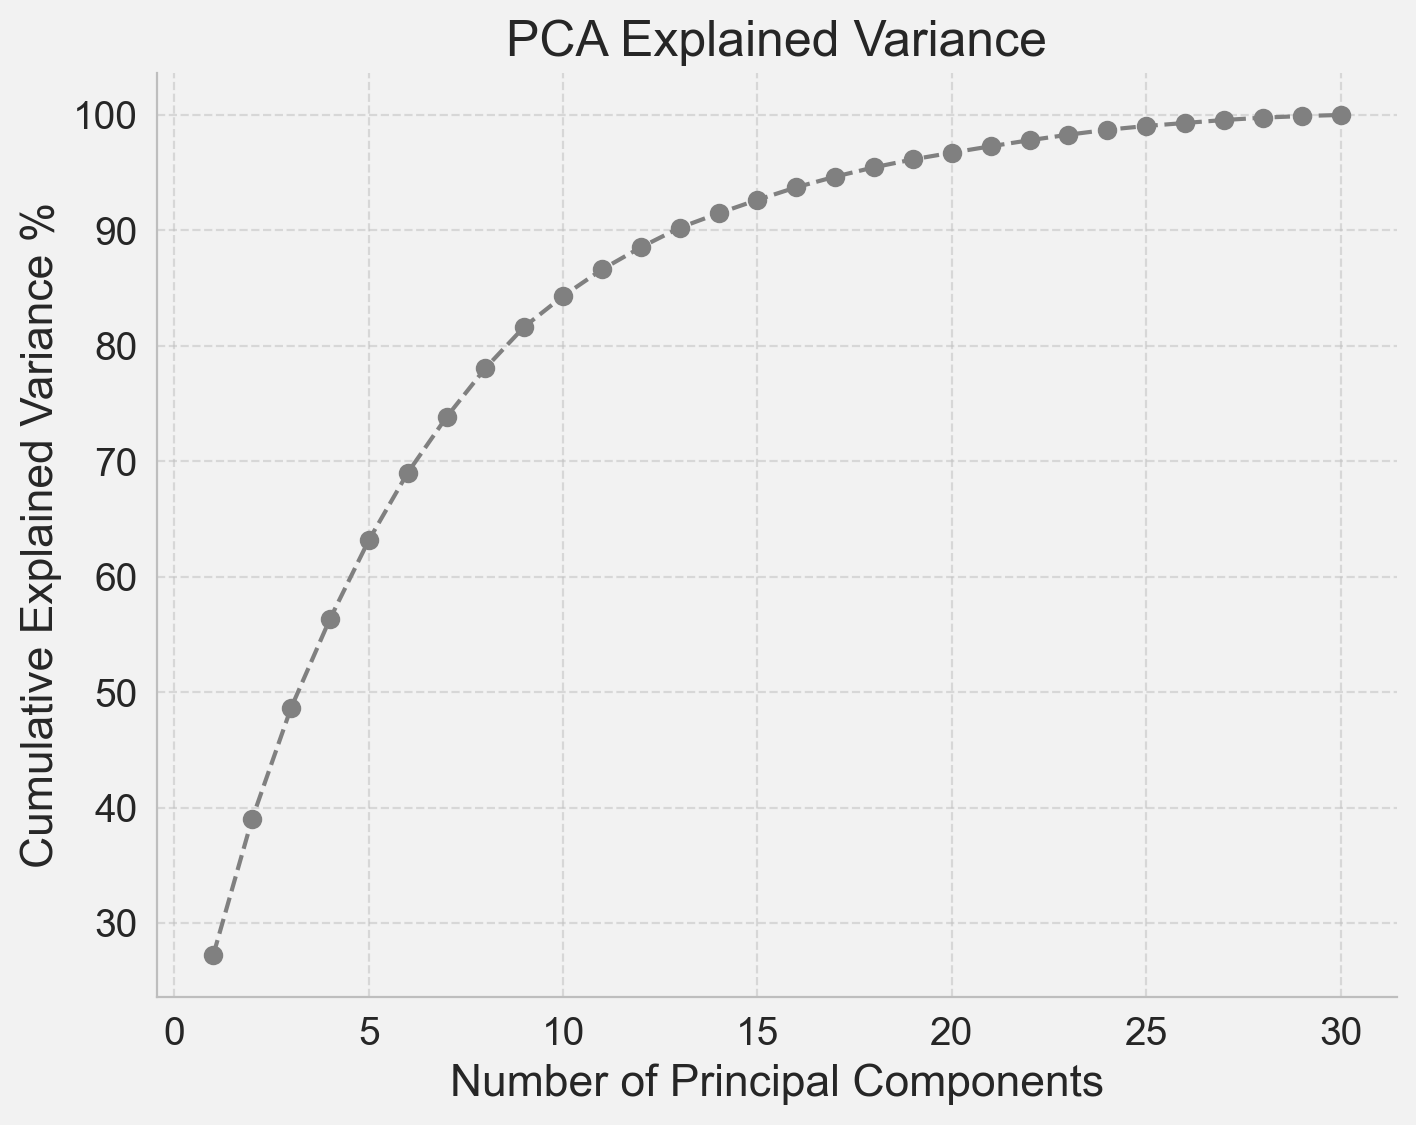

In [146]:
# Perform PCA for all possible components
pca = PCA()
pca.fit(X)  # Fit PCA on X

# Get the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_*100

# Cumulative explained variance
cumulative_variance = np.cumsum(explained_variance_ratio)


# Plot the elbow curve
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance, marker='o', linestyle='--', color='grey')
plt.title('PCA Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance %')
plt.grid(alpha=0.5)
sns.despine()
plt.show()

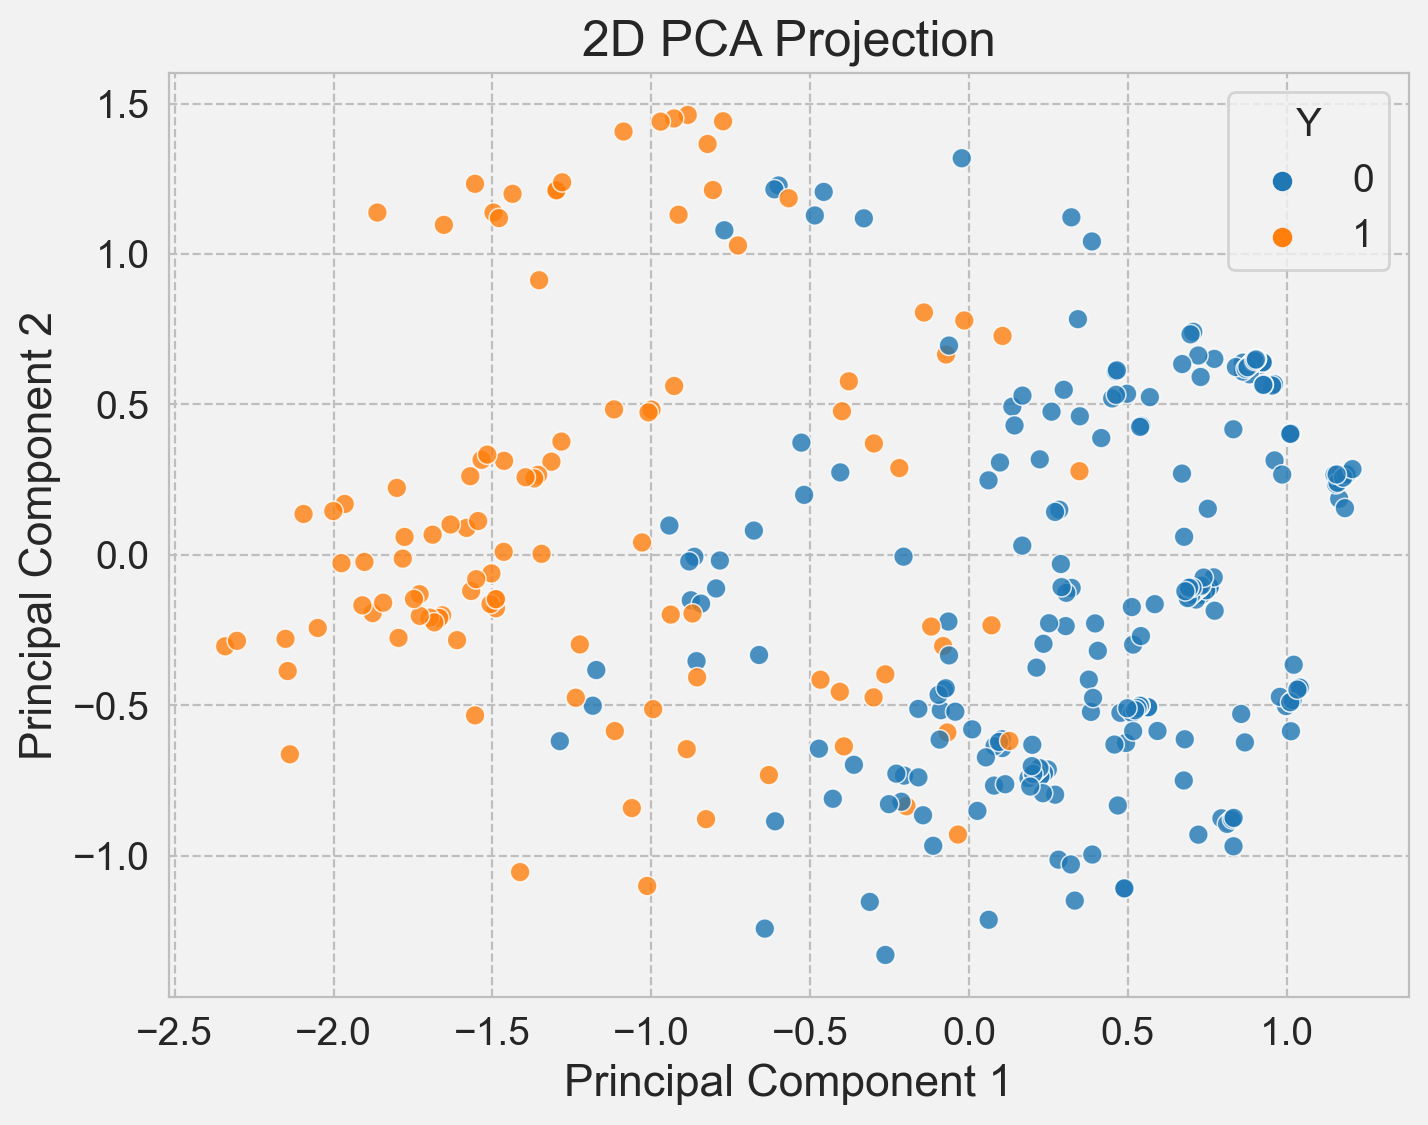

In [147]:
# Assuming X is already preprocessed (transformed) and Y is a pandas Series or array-like
pca = PCA(n_components=2)  # Reduce to 2 dimensions
X_pca = pca.fit_transform(X)  # Perform PCA

# Create a DataFrame for easier plotting
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['Y'] = Y  # Add Y as a column for coloring

# Plot using seaborn scatterplot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Y', palette='tab10', s=50, alpha=0.8)
plt.title('2D PCA Projection')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Y')
plt.show()

/Users/marius/miniconda3/envs/DL/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


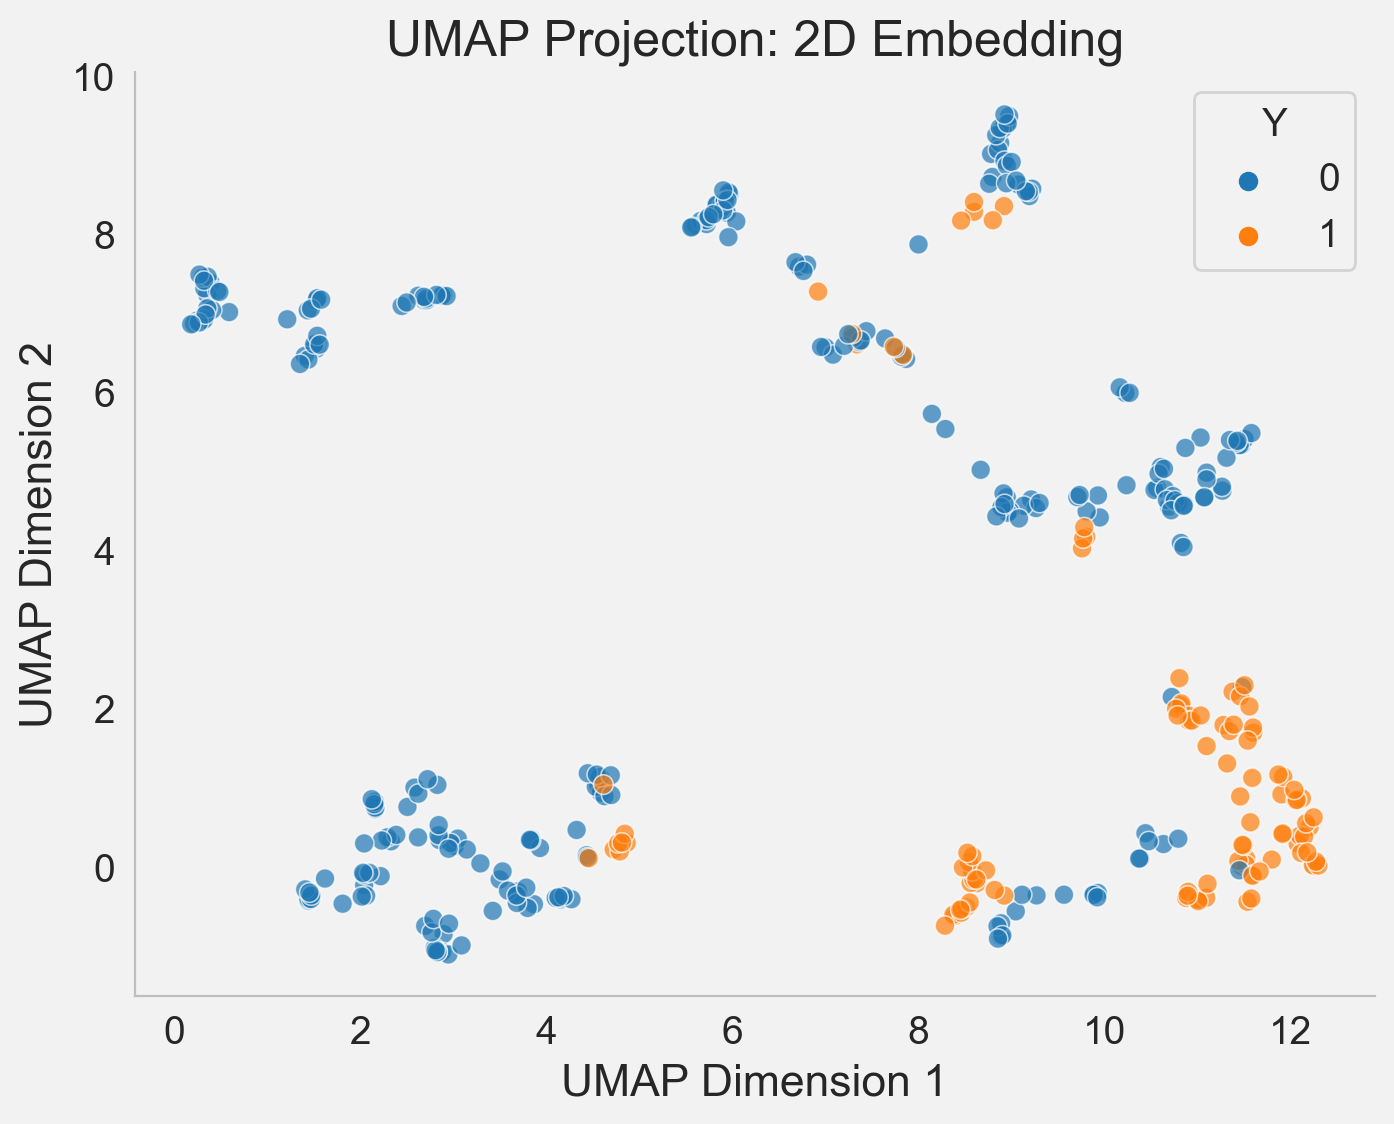

In [167]:
import umap

# Perform UMAP on X
umap_model = umap.UMAP(n_components=2, random_state=42, min_dist=0.1, metric='correlation')
X_umap = umap_model.fit_transform(X)

# Create a DataFrame for the transformed data
umap_df = pd.DataFrame(X_umap, columns=['UMAP1', 'UMAP2'])
umap_df['Y'] = Y  # Add Y as a column for coloring

# Plot the UMAP scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=umap_df, x='UMAP1', y='UMAP2', hue='Y', palette='tab10', s=50, alpha=0.7)
plt.title('UMAP Projection: 2D Embedding')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.legend(title='Y')
plt.grid(False)
sns.despine()
plt.show()


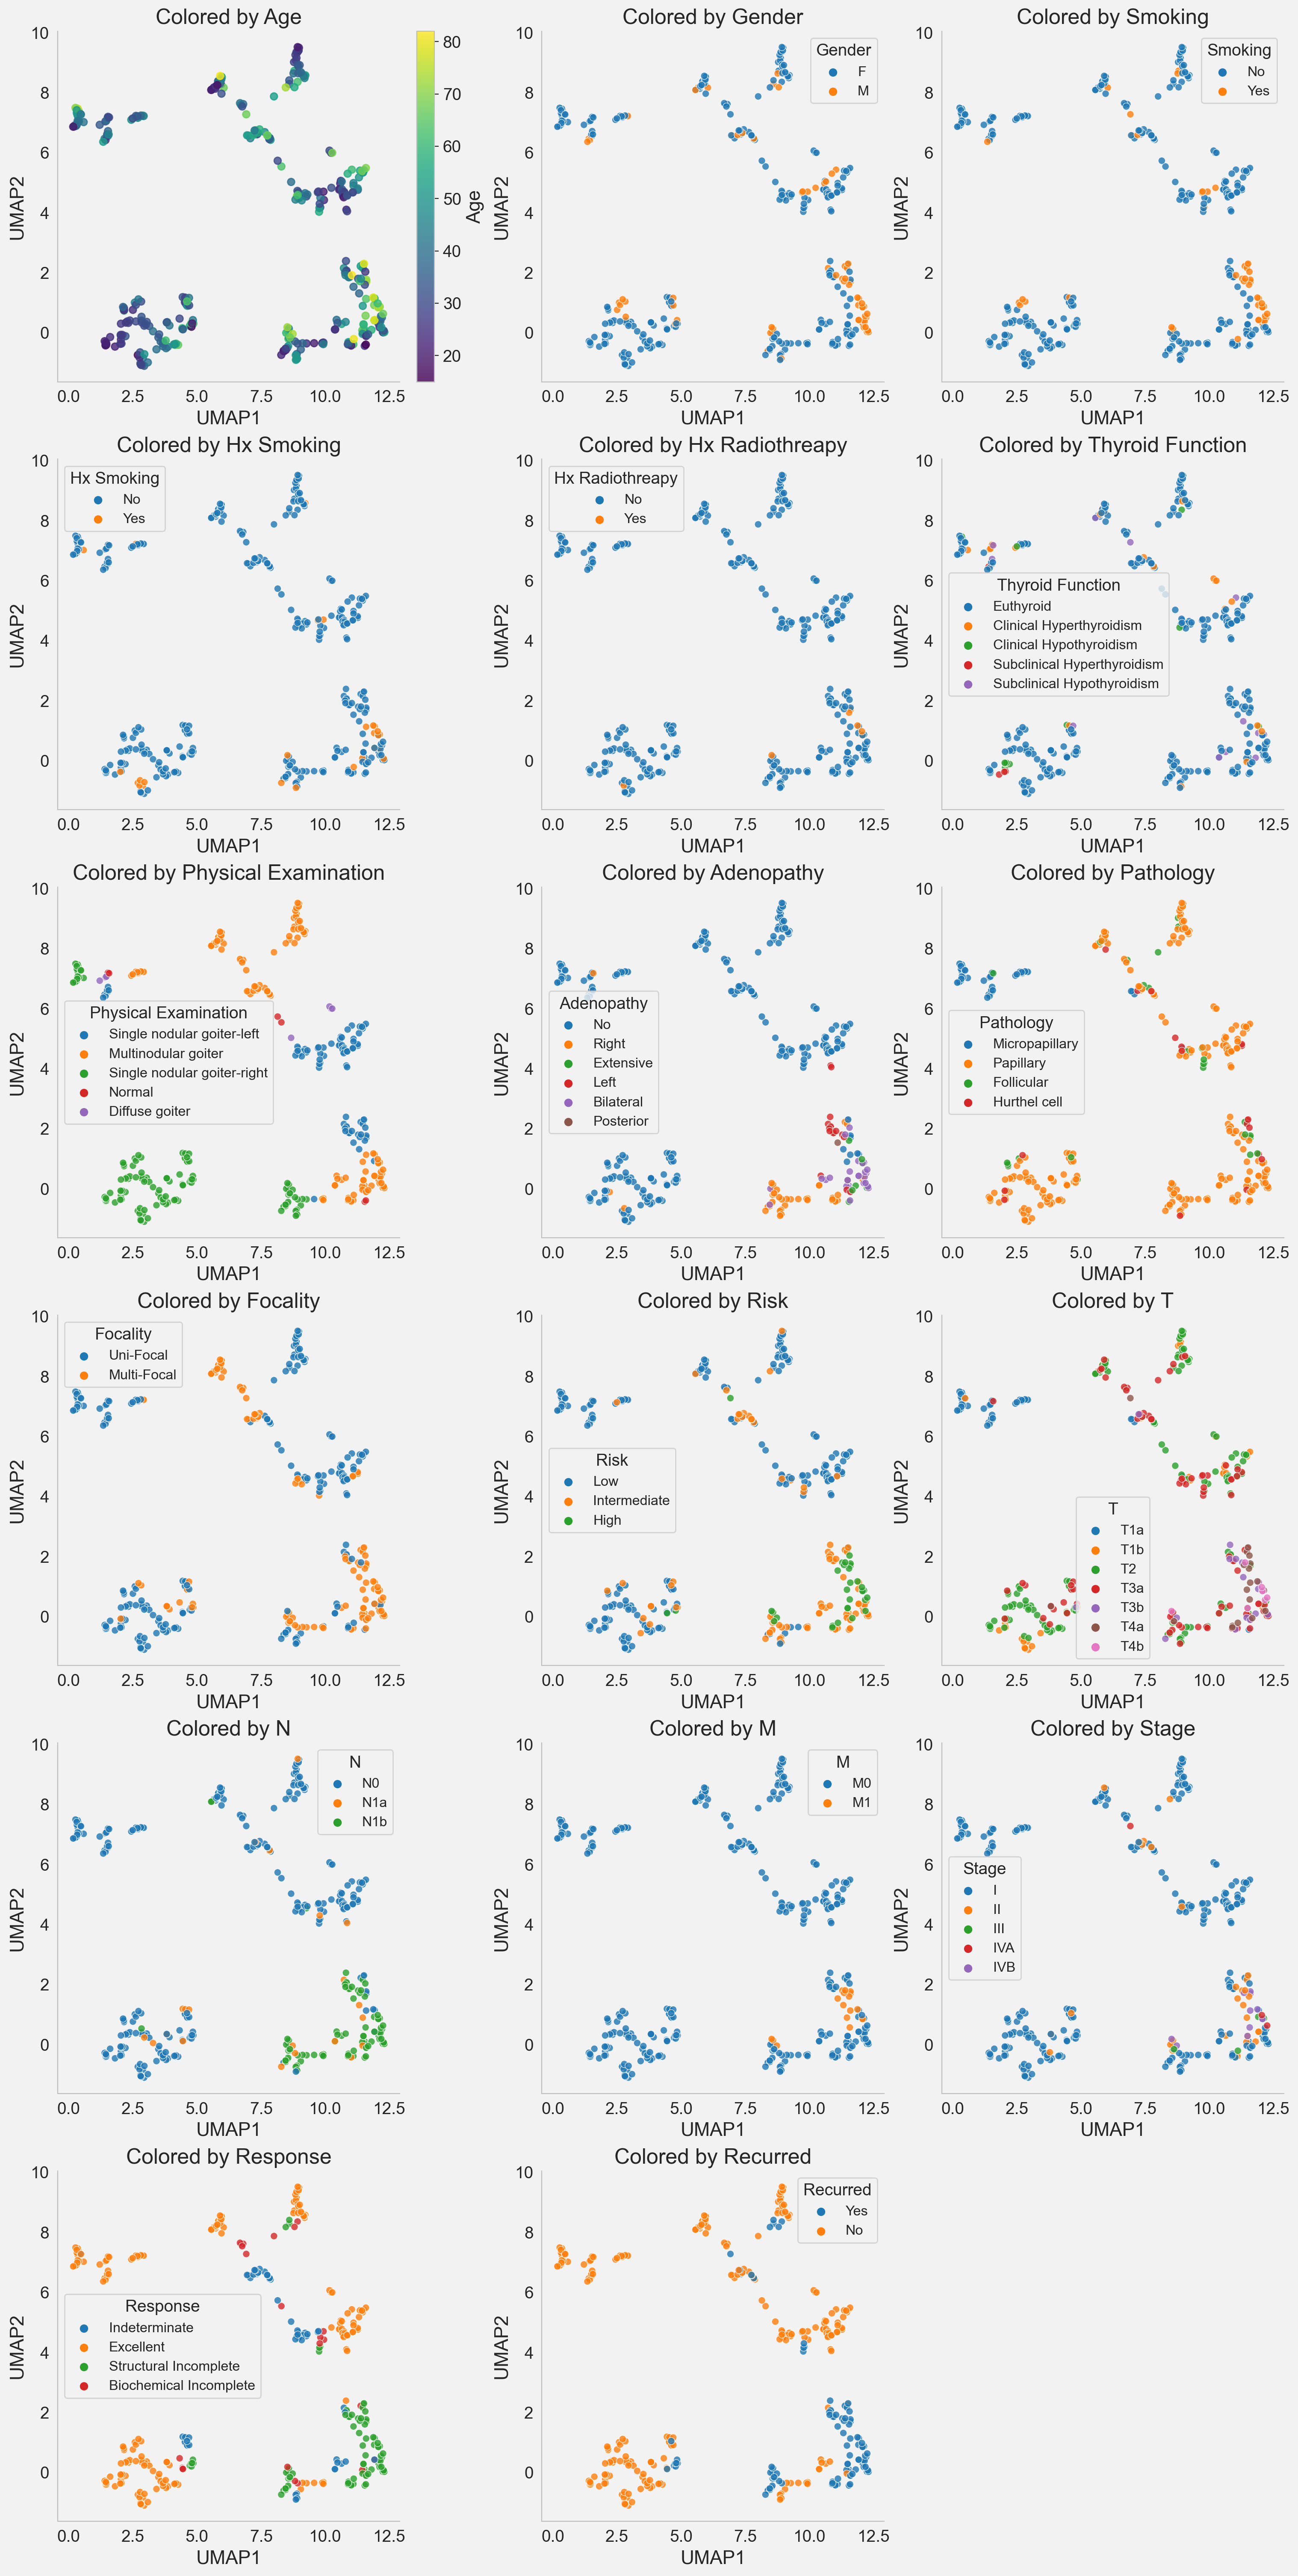

In [168]:


# Create a DataFrame for UMAP results and merge with the original DATA
umap_df = pd.DataFrame(X_umap, columns=['UMAP1', 'UMAP2'])
umap_df = pd.concat([umap_df, DATA], axis=1)  # Combine with original DATA
# Grid of scatterplots
cols = DATA.columns
n_cols = 3  # Number of columns in the grid
n_rows = (len(cols) + n_cols - 1) // n_cols  # Compute rows needed for the grid

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows), constrained_layout=True)
axes = axes.flatten()  # Flatten axes array for easy iteration

# Plot each feature
for i, col in enumerate(cols):
    ax = axes[i]
    if col == 'Age':  # Handle numerical feature
        scatter = ax.scatter(umap_df['UMAP1'], umap_df['UMAP2'], c=umap_df[col], cmap='viridis', alpha=0.8)
        fig.colorbar(scatter, ax=ax, label=col)  # Add a colorbar for numerical features
    else:  # Handle categorical features
        sns.scatterplot(data=umap_df, x='UMAP1', y='UMAP2', hue=col, palette='tab10', ax=ax, alpha=0.8)
        ax.legend(title=col, loc='best', fontsize='small', frameon=True)

    ax.set_title(f'Colored by {col}')
    ax.set_xlabel('UMAP1')
    ax.set_ylabel('UMAP2')
    ax.grid(False)

# Hide unused subplots
for j in range(len(cols), len(axes)):
    axes[j].axis('off')
sns.despine()
plt.show()
